In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

# Find Dependency

In [2]:
find_deps_df = pd.read_csv('../tasks_output/find_deps.csv')
find_deps_df.columns, find_deps_df.shape

(Index(['Benchmark Id', 'Benchmark Name', 'Benchmark Family', 'LTL Formula',
        'Input Variables', 'Output Variables', 'Total Input Variables',
        'Total Output Variables', 'Status', 'Error Message', 'Total Duration',
        'Dependent Variables', 'Total Dependent Variables',
        'Independent Variables', 'Total Independent Variables',
        'Dependency Ratio', 'Is Automaton Built', 'Automaton Build Duration',
        'Automaton Total States', 'Automaton Total Edges', 'Total Pair States',
        'Find Pair States Duration', 'Find Dependency Duration'],
       dtype='object'),
 (1141, 23))

In [3]:
total_deps_df = find_deps_df[find_deps_df["Total Dependent Variables"] > 0][["Benchmark Name", "Benchmark Family", "Total Dependent Variables", "Dependency Ratio"]]
total_deps_df

,Benchmark Name,Benchmark Family,Total Dependent Variables,Dependency Ratio
4,Window2_54e1f7d2,tsl_smart_home_jarvis/extracted-benchmarks,3.0,0.272727
11,LightsTotal_2c5b09da,tsl_smart_home_jarvis/extracted-benchmarks,2.0,0.250000
12,OneCounterGuiA4,tsl_paper,3.0,0.333333
14,Window2_aeb1d897,tsl_smart_home_jarvis/extracted-benchmarks,2.0,0.285714
16,CheckCoffeMachine_f3987563,tsl_smart_home_jarvis/extracted-benchmarks,1.0,0.250000
...,...,...,...,...
1128,EscalatorCounting,tsl_paper,5.0,0.833333
1130,TwoCountersDisButA3,tsl_paper,4.0,0.307692
1135,Shades2_42dc4fff,tsl_smart_home_jarvis/extracted-benchmarks,1.0,0.333333
1137,FelixSpecFixed2_fa4d4ce3,tsl_smart_home_jarvis/extracted-benchmarks,10.0,0.333333


In [4]:
find_deps_df[find_deps_df["Dependency Ratio"] == 1]

,Benchmark Id,Benchmark Name,Benchmark Family,LTL Formula,Input Variables,Output Variables,Total Input Variables,Total Output Variables,Status,Error Message,...,Independent Variables,Total Independent Variables,Dependency Ratio,Is Automaton Built,Automaton Build Duration,Automaton Total States,Automaton Total Edges,Total Pair States,Find Pair States Duration,Find Dependency Duration
32,302,Warnlight_a50cadd7,tsl_smart_home_jarvis/extracted-benchmarks,((((G (! (((u0room29warnlight29control0f1dturn...,"p0b0room29warnlight29off,p0b0room29warnlight29on","u0room29warnlight29control0f1dturn2off1b,u0roo...",2,3,Success,NaN,...,[],0,1.0,True,0.0,1.0,0.0,1.0,0.0,0.0
101,315,SPIWriteClk,tsl_paper,(((G (! (((u0spc0f1dhigh1b) && (! ((u0spc0f1dl...,"p0p0lt0counter0f1dtwentyfour1b,p0p0lt0counter0...","u0spc0f1dlow1b,u0spc0f1dhigh1b,u0spc0spc",5,3,Success,NaN,...,[],0,1.0,True,0.0,1.0,1.0,1.0,0.0,0.0
136,1051,SensorRegister,tsl_paper,((G (! (((u0reg2val0reg2data) && (! (u0reg2val...,p0p0reg2cmp0f1dmy2type1b0reg2type,"u0reg2val0reg2val,u0reg2val0reg2data",1,2,Success,NaN,...,[],0,1.0,True,0.0,1.0,1.0,1.0,0.0,0.0
152,700,Increment,tsl_paper,((G (! (((u0count0count) && (! (u0count0f1dinc...,p0p0event0click,"u0count0f1dincrement0count1b,u0count0count",1,2,Success,NaN,...,[],0,1.0,True,0.0,1.0,1.0,1.0,0.0,0.0
164,489,shift16,shift,(G (((((((((((((((((in_0) <-> (out_1)) && ((in...,"in_0,in_1,in_2,in_3,in_4,in_5,in_6,in_7,in_8,i...","out_0,out_1,out_2,out_3,out_4,out_5,out_6,out_...",16,16,Success,NaN,...,[],0,1.0,True,1.0,1.0,1.0,1.0,0.0,408.0
180,1108,shift12,shift,(G (((((((((((((in_0) <-> (out_1)) && ((in_1) ...,"in_0,in_1,in_2,in_3,in_4,in_5,in_6,in_7,in_8,i...","out_0,out_1,out_2,out_3,out_4,out_5,out_6,out_...",12,12,Success,NaN,...,[],0,1.0,True,1.0,1.0,1.0,1.0,0.0,16.0
190,846,RegManager,tsl_paper,((((((G (((! (((u0buffer0buffer) && (! (u0buff...,"p0p0secondhalf0reg2manager2cmd,p0p0firsthalf0r...","u0reg2type0f1dextract2reg0reg2manager2cmd1b,u0...",2,8,Success,NaN,...,[],0,1.0,True,1.0,1.0,1.0,1.0,0.0,1.0
199,271,ActionConverter,tsl_paper,(((((G ((! (((u0gamestart0f1dbot1b) && (! ((u0...,"p0p0norotation0gyrox0gyroy0gyroz,p0p0gt0f1dabs...","u0shot0f1dtop1b,u0shot0f1dbot1b,u0shot0shot,u0...",5,6,Success,NaN,...,[],0,1.0,True,0.0,1.0,1.0,1.0,0.0,1.0
282,573,Button,tsl_paper,(((G ((! (((u0count0count) && (! (u0count0f1di...,p0p0event0click,"u0pic0f1drender2button0count1b,u0pic0pic,u0cou...",1,4,Success,NaN,...,[],0,1.0,True,0.0,1.0,1.0,1.0,0.0,0.0
337,599,mux16,mux,(G (((((((((((((((((((((true) && (! (select_3)...,"in_0,in_1,in_2,in_3,in_4,in_5,in_6,in_7,in_8,i...",out,20,1,Success,NaN,...,[],0,1.0,True,1.0,1.0,1.0,1.0,0.0,0.0


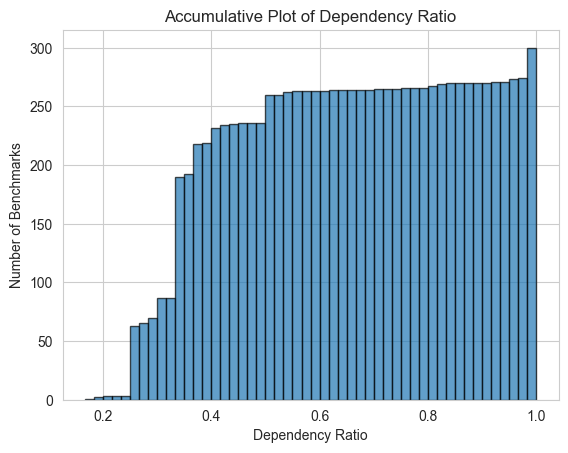

In [5]:
plt.hist(find_deps_df[find_deps_df["Total Dependent Variables"] > 0]['Dependency Ratio'], bins=50, cumulative=True, edgecolor='k', alpha=0.7)
plt.xlabel('Dependency Ratio')
plt.ylabel('Number of Benchmarks')
plt.title('Accumulative Plot of Dependency Ratio')
plt.grid(True)
plt.show()

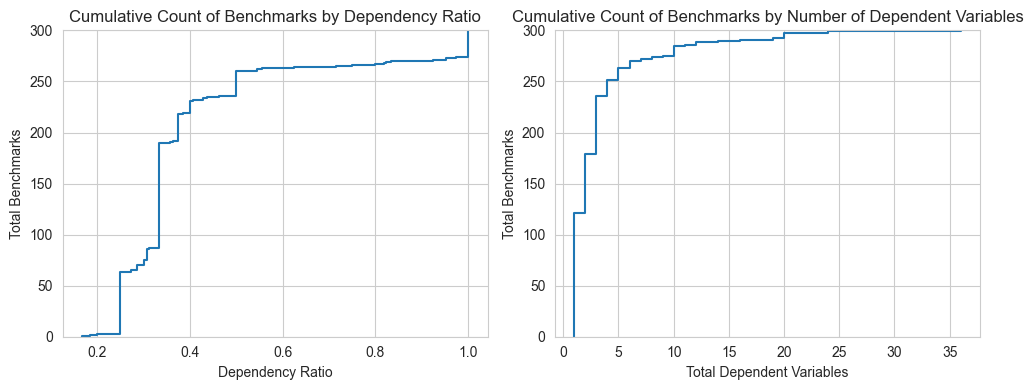

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Plot the first graph on the first subplot
sns.ecdfplot(data=total_deps_df, x="Dependency Ratio", stat="count", ax=axes[0])
axes[0].set_title("Cumulative Count of Benchmarks by Dependency Ratio")
axes[0].set_ylabel("Total Benchmarks")

# Plot the second graph on the second subplot
sns.ecdfplot(data=total_deps_df, x="Total Dependent Variables", stat="count", ax=axes[1])
axes[1].set_title("Cumulative Count of Benchmarks by Number of Dependent Variables")
axes[1].set_ylabel("Total Benchmarks")

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

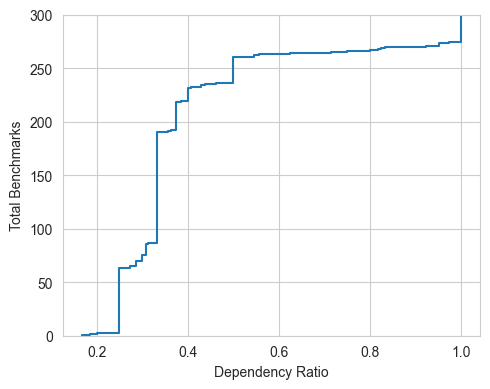

In [26]:
fig, axes = plt.subplots(1, 1, figsize=(5, 4))

# Plot the first graph on the first subplot
sns.ecdfplot(data=total_deps_df, x="Dependency Ratio", stat="count", ax=axes)
# axes[0].set_title("Cumulative Count of Benchmarks by Dependency Ratio")
axes.set_ylabel("Total Benchmarks")

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

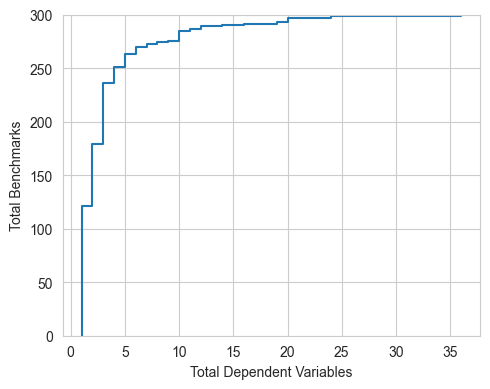

In [28]:
fig, axes = plt.subplots(1, 1, figsize=(5, 4))

# Plot the second graph on the second subplot
sns.ecdfplot(data=total_deps_df, x="Total Dependent Variables", stat="count", ax=axes)
# axes.set_title("Cumulative Count of Benchmarks by Number of Dependent Variables")
axes.set_ylabel("Total Benchmarks")

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

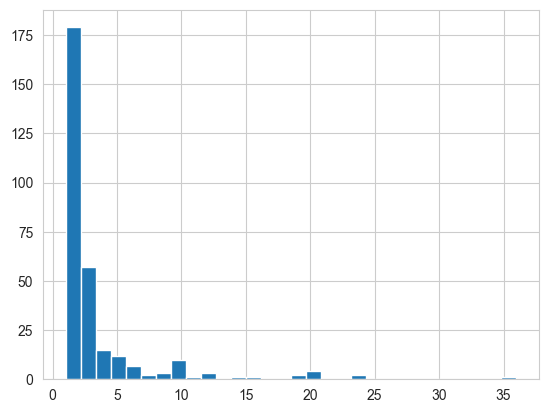

In [7]:
ax = plt.hist(total_deps_df["Total Dependent Variables"], bins=30)

In [8]:
# Filter DataFrame to only include rows where Status is Success
success_df = find_deps_df[find_deps_df['Status'] == 'Success']

# Group by Benchmark Family and calculate the mean Dependency Ratio
average_dependency_ratio = success_df.groupby('Benchmark Family')['Dependency Ratio'].mean()
average_dependency_ratio[average_dependency_ratio > 0]

Benchmark Family
ltl2dpa                                       0.434028
mux                                           0.333333
shift                                         1.000000
tsl_paper                                     0.457427
tsl_smart_home_jarvis/extracted-benchmarks    0.309888
Name: Dependency Ratio, dtype: float64

# DepSynt Tool

In [9]:
depsynt_df = pd.read_csv('../tasks_output/depsynt.csv')
headers = {
    "AUTOMATON_BUILD": "Automaton Build Duration",
    "FIND_DEPS_DURATION": "Find Dependency Duration",
    "INDEPENDENTS_SYNTHESIS": "Independent Synthesis Duration",
    "DEPENDENTS_SYNTHESIS": "Dependent Synthesis Duration",
}
headers_list = list(headers.values())
# Quick hack for now
depsynt_df['Total Independent Variables'] = depsynt_df['Total Output Variables'] - depsynt_df['Total Dependent Variables']

depsynt_df.columns

Index(['Benchmark Id', 'Benchmark Name', 'Benchmark Family', 'LTL Formula',
       'Input Variables', 'Output Variables', 'Total Input Variables',
       'Total Output Variables', 'Status', 'Error Message', 'Total Duration',
       'Dependent Variables', 'Total Dependent Variables',
       'Independent Variables', 'Total Independent Variables',
       'Dependency Ratio', 'Is Automaton Built', 'Automaton Build Duration',
       'Automaton Total States', 'Automaton Total Edges', 'Total Pair States',
       'Find Pair States Duration', 'Find Dependency Duration',
       'Realizability', 'Independent Synthesis Duration',
       'Dependent Synthesis Duration', 'Merge Strategies Duration',
       'Synthesis Duration'],
      dtype='object')

In [10]:
X = depsynt_df[depsynt_df["Status"] == 'Success']
X = X[headers_list + ["Total Duration"]].copy()
X["Gap Total Duration and Rest"] = depsynt_df["Total Duration"] - depsynt_df[headers_list].sum(axis=1)

X.sort_values(by="Gap Total Duration and Rest", ascending=False, inplace=True)
X

,Automaton Build Duration,Find Dependency Duration,Independent Synthesis Duration,Dependent Synthesis Duration,Total Duration,Gap Total Duration and Rest
331,1690902.0,12000.0,1417631.0,0.0,3120657.0,124.0
129,497.0,13135.0,1771.0,118.0,15531.0,10.0
245,599.0,14964.0,5251335.0,143.0,5267051.0,10.0
143,371.0,13925.0,539.0,149.0,14993.0,9.0
38,238.0,6736.0,5079484.0,78.0,5086544.0,8.0
...,...,...,...,...,...,...
94,3.0,0.0,1.0,0.0,4.0,0.0
128,1.0,0.0,1.0,0.0,2.0,0.0
220,1.0,0.0,1.0,0.0,2.0,0.0
148,1.0,0.0,1.0,0.0,2.0,0.0


In [11]:
spot_modular_df = pd.read_csv('../tasks_output/spotmodular.csv')
spot_modular_df = spot_modular_df.merge(find_deps_df[["Benchmark Id", "Total Dependent Variables", "Total Independent Variables"]], on='Benchmark Id')
spot_modular_df = spot_modular_df[spot_modular_df["Total Dependent Variables_y"] > 0]
spot_modular_df

,Benchmark Id,Benchmark Name,Benchmark Family,LTL Formula,Input Variables,Output Variables,Total Input Variables,Total Output Variables,Status,Error Message,...,Total Pair States,Find Pair States Duration,Find Dependency Duration,Realizability,Independent Synthesis Duration,Dependent Synthesis Duration,Merge Strategies Duration,Synthesis Duration,Total Dependent Variables_y,Total Independent Variables_y
0,1090,Window2_54e1f7d2,tsl_smart_home_jarvis/extracted-benchmarks,((G (((! (((! (((u0room29light0f1dtoggle1b) &&...,"p0p0too2high0room29co252level,p0p0all2windows2...","u0room29warnlight29control0f1dturn2off1b,u0roo...",9,11,Success,NaN,...,-1.0,NaN,-1.0,REALIZABLE,1.0,0.0,NaN,1.0,3.0,8
2,921,LightsTotal_2c5b09da,tsl_smart_home_jarvis/extracted-benchmarks,((G ((! (((! (((u02timer29start2new2timer0f1d2...,"p0p0bright0outside29brightness,p0b02room29bed2...","u02roomlight29light0f1d2roomlight29turn2off1b,...",11,8,Success,NaN,...,-1.0,NaN,-1.0,UNREALIZABLE,34314.0,0.0,NaN,34314.0,2.0,6
3,935,OneCounterGuiA4,tsl_paper,((G (((! (((u0button2down0f1ddisable1b) && (! ...,"p0p0in2range0f1dinc0f1dinc0counter1b1b,p0p0in2...","u0counter0f1dinc0counter1b,u0counter0f1ddec0co...",9,9,Success,NaN,...,-1.0,NaN,-1.0,UNREALIZABLE,41.0,0.0,NaN,41.0,3.0,6
4,712,Window2_aeb1d897,tsl_smart_home_jarvis/extracted-benchmarks,((G ((! (((! (((u02timer29start2new2timer0f1d2...,"p0p0too2high0room29co252level,p0p02window29all...",u02warnlight29control0f1d2warnlight29turn2off1...,7,7,Success,NaN,...,-1.0,NaN,-1.0,REALIZABLE,32.0,0.0,NaN,32.0,2.0,5
5,869,CheckCoffeMachine_f3987563,tsl_smart_home_jarvis/extracted-benchmarks,((G (! (((! (((u02device29ctrl0f1d2device29mak...,"p0b02device29finished,p0b02device29busy,p0b02d...","u02device29ctrl0f1d2device29turn2off1b,u02devi...",4,4,Success,NaN,...,-1.0,NaN,-1.0,UNREALIZABLE,2.0,0.0,NaN,2.0,1.0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
349,938,EscalatorCounting,tsl_paper,(((((G ((! (((u0steps0f1dmove1b) && (! ((u0ste...,"p0p0zero0users,p0p0exit2event0top,p0p0enter2ev...","u0users0f1dinc0users1b,u0users0f1ddec0users1b,...",3,6,Success,NaN,...,-1.0,NaN,-1.0,REALIZABLE,1.0,0.0,NaN,1.0,5.0,1
350,904,TwoCountersDisButA3,tsl_paper,((G ((((! (((u0first2counter0f1ddecrement0firs...,"p0p0second0selected,p0p0in2range0f1dincrement0...","u0window0f1denable2button0up1b,u0window0f1dena...",11,13,Success,NaN,...,-1.0,NaN,-1.0,UNREALIZABLE,1148.0,0.0,NaN,1148.0,4.0,9
351,509,Shades2_42dc4fff,tsl_smart_home_jarvis/extracted-benchmarks,((G (! (((u02shades29ctrl0f1d2shades29move2to0...,"p0p0bright0outside29brightness,p0b0room29scree...",u02shades29ctrl0f1d2shades29move2to0f1d2shades...,4,3,Success,NaN,...,-1.0,NaN,-1.0,REALIZABLE,4.0,0.0,NaN,4.0,1.0,2
352,1062,FelixSpecFixed2_fa4d4ce3,tsl_smart_home_jarvis/extracted-benchmarks,((G ((((((((((! (((! (((u0cm29ctrl0f1dmake2cof...,"p0p0gt0outside29temperature0room29temperature,...","u0tv29ctrl0f1dturn2on1b,u0tv29ctrl0tv29ctrl,u0...",36,30,Success,NaN,...,-1.0,NaN,-1.0,REALIZABLE,0.0,0.0,NaN,0.0,10.0,20


In [12]:
def gen_stackplot(should_include_row, plt_title, df, sort_by = None, normalize = True):
    # Generate DF
    stackplot_df = df.copy()

    # Clip minimal values
    stackplot_df[headers_list + ["Synthesis Duration"]] = stackplot_df[headers_list + ["Synthesis Duration"]].clip(lower=0)

    # Sorting
    if sort_by != None:
        stackplot_df.sort_values(by=sort_by, ascending=True, inplace=True)
    
    # Resolve Total Duration
    stackplot_df["Total Duration"] = stackplot_df[headers_list].sum(axis=1)

    # Filtering
    stackplot_df = stackplot_df[stackplot_df.apply(should_include_row, axis=1)]

    if normalize:
        stackplot_df[headers['AUTOMATON_BUILD']] /= stackplot_df["Total Duration"]
        stackplot_df[headers['FIND_DEPS_DURATION']] /= stackplot_df["Total Duration"]
        stackplot_df[headers['INDEPENDENTS_SYNTHESIS']] /= stackplot_df["Total Duration"]
        stackplot_df[headers['DEPENDENTS_SYNTHESIS']] /= stackplot_df["Total Duration"]
    
    # return stackplot_df

    plt.figure(figsize=(15,6))
    x = range(0, len(stackplot_df))
    legend_headers = [
        'Synthesis dependents',
        'Synthesis non-dependents',
        'Find Deps',
        'Build Automaton',
    ]
    color_map = ["#808080", "#ffffff", "#FF5733", "#000000"]

    plt.stackplot(x,
                stackplot_df[headers['DEPENDENTS_SYNTHESIS']],
                stackplot_df[headers['INDEPENDENTS_SYNTHESIS']],
                stackplot_df[headers['FIND_DEPS_DURATION']],
                stackplot_df[headers['AUTOMATON_BUILD']],
                labels=legend_headers, colors = color_map
    )
    # plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.xlabel('Benchmarks')
    plt.ylabel('')
    if not normalize:
        plt.yscale('symlog')
    plt.title(plt_title)
    # plt.xticks(x)  # This will ensure each ID is shown on the x-axis
    plt.tight_layout()
    plt.show()

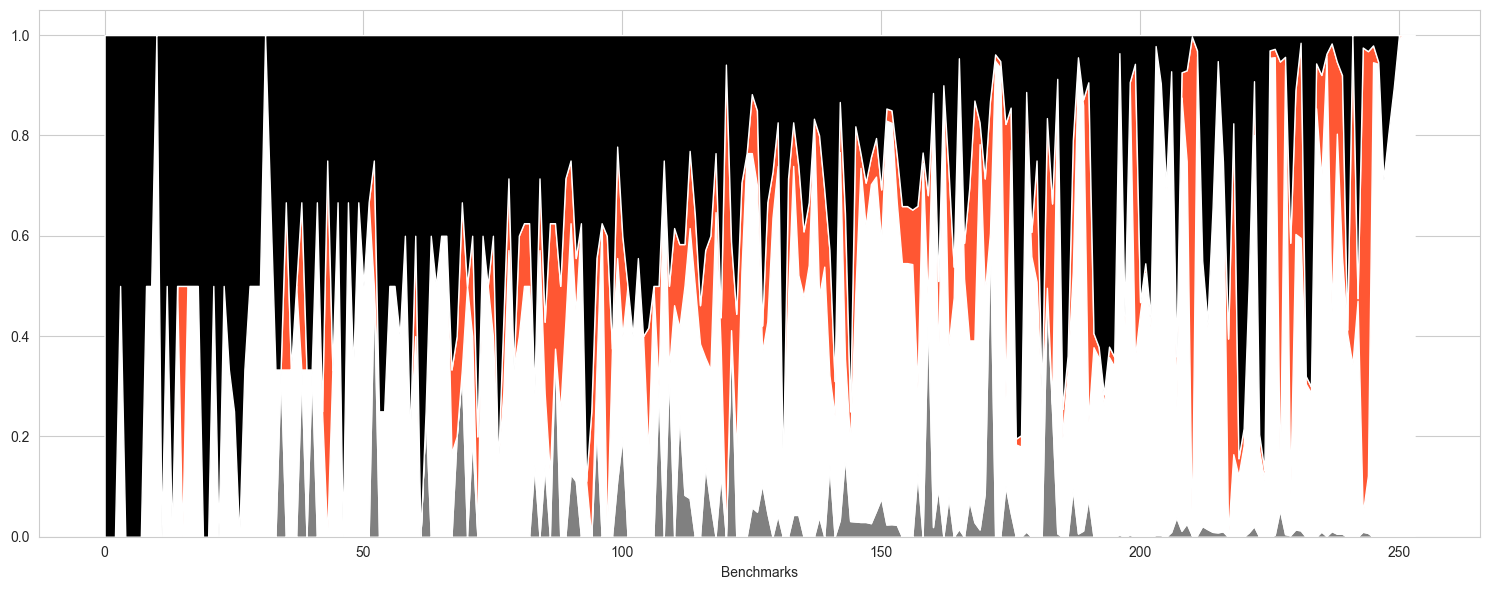

In [13]:
def should_include_row(row):
    status = row["Status"]
    total_duration = row["Total Duration"]
    total_deps_var = row["Total Dependent Variables"]
    total_indeps_var = row["Total Independent Variables"]
    
    if total_duration <= 0:
        return False
    if status != "Success":
        return False
    if total_deps_var == 0:
        return False
    
    return True

# sort_by = "Automaton Total States"
sort_by = "Total Duration"
# title = f"DepSynt Time Distribution (Sorted By {sort_by})"
title = ""
gen_stackplot(should_include_row, title, depsynt_df, sort_by=sort_by, normalize=True)

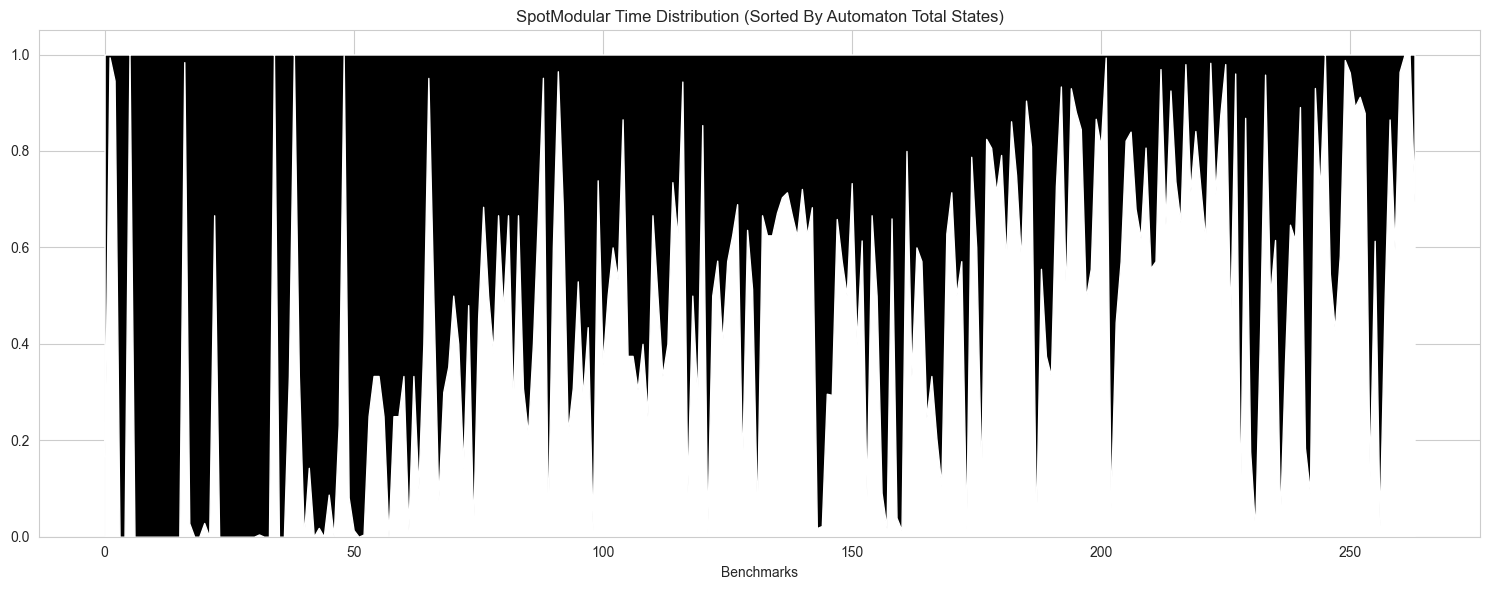

In [14]:
def should_include_row(row):
    status = row["Status"]
    total_duration = row["Total Duration"]
    # total_deps_var = row["Total Dependent Variables"]
    # total_indeps_var = row["Total Independent Variables"]

    if total_duration <= 0:
        return False
    if status != "Success":
        return False
    # if total_deps_var == 0:
    #     return False

    return True

sort_by = "Automaton Total States"
title = f"SpotModular Time Distribution (Sorted By {sort_by})"
gen_stackplot(should_include_row, title, spot_modular_df, sort_by=sort_by, normalize=True)

# BDD Changes

In [15]:
depsynt_bdd_measures_df = pd.read_csv('../tasks_output/depsynt_measure.csv')
depsynt_bdd_measures_df[(depsynt_bdd_measures_df["Status"] == "Success") & (depsynt_bdd_measures_df["Total Dependent Variables"] > 0)]

,Benchmark Id,Benchmark Name,Benchmark Family,LTL Formula,Input Variables,Output Variables,Total Input Variables,Total Output Variables,Status,Error Message,...,Projected Min BDD Size,Projected Total BDDs Instances,Projected Total BDDs Size (Not Repeated),Projected Total BDDs Size (Repeated),Origin Average BDD Size,Origin Max BDD Size,Origin Min BDD Size,Origin Total BDDs Instances,Origin Total BDDs Size (Not Repeated),Origin Total BDDs Size (Repeated)
0,1090,Window2_54e1f7d2,tsl_smart_home_jarvis/extracted-benchmarks,((G (((! (((! (((u0room29light0f1dtoggle1b) &&...,"p0p0too2high0room29co252level,p0p0all2windows2...","u0room29warnlight29control0f1dturn2off1b,u0roo...",9,11,Success,NaN,...,10.0,1.0,10.0,10.0,19.0,19.0,19.0,1.0,19.0,19.0
2,921,LightsTotal_2c5b09da,tsl_smart_home_jarvis/extracted-benchmarks,((G ((! (((! (((u02timer29start2new2timer0f1d2...,"p0p0bright0outside29brightness,p0b02room29bed2...","u02roomlight29light0f1d2roomlight29turn2off1b,...",11,8,Success,NaN,...,7.0,144.0,2304.0,10367.0,22.0,42.0,13.0,144.0,3252.0,14785.0
3,935,OneCounterGuiA4,tsl_paper,((G (((! (((u0button2down0f1ddisable1b) && (! ...,"p0p0in2range0f1dinc0f1dinc0counter1b1b,p0p0in2...","u0counter0f1dinc0counter1b,u0counter0f1ddec0co...",9,9,Success,NaN,...,6.0,24.0,276.0,276.0,20.0,72.0,15.0,24.0,484.0,484.0
4,712,Window2_aeb1d897,tsl_smart_home_jarvis/extracted-benchmarks,((G ((! (((! (((u02timer29start2new2timer0f1d2...,"p0p0too2high0room29co252level,p0p02window29all...",u02warnlight29control0f1d2warnlight29turn2off1...,7,7,Success,NaN,...,6.0,54.0,708.0,1034.0,19.0,33.0,12.0,54.0,1051.0,1544.0
5,869,CheckCoffeMachine_f3987563,tsl_smart_home_jarvis/extracted-benchmarks,((G (! (((! (((u02device29ctrl0f1d2device29mak...,"p0b02device29finished,p0b02device29busy,p0b02d...","u02device29ctrl0f1d2device29turn2off1b,u02devi...",4,4,Success,NaN,...,3.0,24.0,139.0,239.0,8.0,12.0,6.0,24.0,205.0,350.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
346,657,LightsMin_6bea956e,tsl_smart_home_jarvis/extracted-benchmarks,((G (! (((! (((u0room29light0f1dtoggle1b) && (...,"p0b0room29empty,p0b0room29light29off,p0b0room2...","u0room29light0f1dturn2off1b,u0room29light0f1dt...",3,4,Success,NaN,...,3.0,15.0,89.0,136.0,9.0,11.0,7.0,15.0,135.0,207.0
349,938,EscalatorCounting,tsl_paper,(((((G ((! (((u0steps0f1dmove1b) && (! ((u0ste...,"p0p0zero0users,p0p0exit2event0top,p0p0enter2ev...","u0users0f1dinc0users1b,u0users0f1ddec0users1b,...",3,6,Success,NaN,...,1.0,6.0,14.0,21.0,16.0,21.0,12.0,6.0,97.0,158.0
350,904,TwoCountersDisButA3,tsl_paper,((G ((((! (((u0first2counter0f1ddecrement0firs...,"p0p0second0selected,p0p0in2range0f1dincrement0...","u0window0f1denable2button0up1b,u0window0f1dena...",11,13,Success,NaN,...,10.0,21.0,904.0,904.0,60.0,527.0,22.0,21.0,1261.0,1261.0
351,509,Shades2_42dc4fff,tsl_smart_home_jarvis/extracted-benchmarks,((G (! (((u02shades29ctrl0f1d2shades29move2to0...,"p0p0bright0outside29brightness,p0b0room29scree...",u02shades29ctrl0f1d2shades29move2to0f1d2shades...,4,3,Success,NaN,...,2.0,15.0,54.0,100.0,6.0,10.0,5.0,15.0,95.0,179.0


BDD_Change = \frac{BDD Origin Size - BDD Projected Size} / {BDD Origin Size} = 1 - {BDD Projected Size} /BDD Origin Size

In [16]:
X = depsynt_bdd_measures_df[(depsynt_bdd_measures_df["Status"] == "Success") & (depsynt_bdd_measures_df["Total Dependent Variables"] > 0)].copy()
X["BDD Size Loss (Repeated)"] = (1 - (depsynt_bdd_measures_df["Projected Total BDDs Size (Repeated)"] / depsynt_bdd_measures_df["Origin Total BDDs Size (Repeated)"])).fillna(0)
X["BDD Size Loss (Not Repeated)"] = (1 - (depsynt_bdd_measures_df["Projected Total BDDs Size (Not Repeated)"] / depsynt_bdd_measures_df["Origin Total BDDs Size (Not Repeated)"])).fillna(0)
X

,Benchmark Id,Benchmark Name,Benchmark Family,LTL Formula,Input Variables,Output Variables,Total Input Variables,Total Output Variables,Status,Error Message,...,Projected Total BDDs Size (Not Repeated),Projected Total BDDs Size (Repeated),Origin Average BDD Size,Origin Max BDD Size,Origin Min BDD Size,Origin Total BDDs Instances,Origin Total BDDs Size (Not Repeated),Origin Total BDDs Size (Repeated),BDD Size Loss (Repeated),BDD Size Loss (Not Repeated)
0,1090,Window2_54e1f7d2,tsl_smart_home_jarvis/extracted-benchmarks,((G (((! (((! (((u0room29light0f1dtoggle1b) &&...,"p0p0too2high0room29co252level,p0p0all2windows2...","u0room29warnlight29control0f1dturn2off1b,u0roo...",9,11,Success,NaN,...,10.0,10.0,19.0,19.0,19.0,1.0,19.0,19.0,0.473684,0.473684
2,921,LightsTotal_2c5b09da,tsl_smart_home_jarvis/extracted-benchmarks,((G ((! (((! (((u02timer29start2new2timer0f1d2...,"p0p0bright0outside29brightness,p0b02room29bed2...","u02roomlight29light0f1d2roomlight29turn2off1b,...",11,8,Success,NaN,...,2304.0,10367.0,22.0,42.0,13.0,144.0,3252.0,14785.0,0.298816,0.291513
3,935,OneCounterGuiA4,tsl_paper,((G (((! (((u0button2down0f1ddisable1b) && (! ...,"p0p0in2range0f1dinc0f1dinc0counter1b1b,p0p0in2...","u0counter0f1dinc0counter1b,u0counter0f1ddec0co...",9,9,Success,NaN,...,276.0,276.0,20.0,72.0,15.0,24.0,484.0,484.0,0.429752,0.429752
4,712,Window2_aeb1d897,tsl_smart_home_jarvis/extracted-benchmarks,((G ((! (((! (((u02timer29start2new2timer0f1d2...,"p0p0too2high0room29co252level,p0p02window29all...",u02warnlight29control0f1d2warnlight29turn2off1...,7,7,Success,NaN,...,708.0,1034.0,19.0,33.0,12.0,54.0,1051.0,1544.0,0.330311,0.326356
5,869,CheckCoffeMachine_f3987563,tsl_smart_home_jarvis/extracted-benchmarks,((G (! (((! (((u02device29ctrl0f1d2device29mak...,"p0b02device29finished,p0b02device29busy,p0b02d...","u02device29ctrl0f1d2device29turn2off1b,u02devi...",4,4,Success,NaN,...,139.0,239.0,8.0,12.0,6.0,24.0,205.0,350.0,0.317143,0.321951
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
346,657,LightsMin_6bea956e,tsl_smart_home_jarvis/extracted-benchmarks,((G (! (((! (((u0room29light0f1dtoggle1b) && (...,"p0b0room29empty,p0b0room29light29off,p0b0room2...","u0room29light0f1dturn2off1b,u0room29light0f1dt...",3,4,Success,NaN,...,89.0,136.0,9.0,11.0,7.0,15.0,135.0,207.0,0.342995,0.340741
349,938,EscalatorCounting,tsl_paper,(((((G ((! (((u0steps0f1dmove1b) && (! ((u0ste...,"p0p0zero0users,p0p0exit2event0top,p0p0enter2ev...","u0users0f1dinc0users1b,u0users0f1ddec0users1b,...",3,6,Success,NaN,...,14.0,21.0,16.0,21.0,12.0,6.0,97.0,158.0,0.867089,0.855670
350,904,TwoCountersDisButA3,tsl_paper,((G ((((! (((u0first2counter0f1ddecrement0firs...,"p0p0second0selected,p0p0in2range0f1dincrement0...","u0window0f1denable2button0up1b,u0window0f1dena...",11,13,Success,NaN,...,904.0,904.0,60.0,527.0,22.0,21.0,1261.0,1261.0,0.283109,0.283109
351,509,Shades2_42dc4fff,tsl_smart_home_jarvis/extracted-benchmarks,((G (! (((u02shades29ctrl0f1d2shades29move2to0...,"p0p0bright0outside29brightness,p0b0room29scree...",u02shades29ctrl0f1d2shades29move2to0f1d2shades...,4,3,Success,NaN,...,54.0,100.0,6.0,10.0,5.0,15.0,95.0,179.0,0.441341,0.431579


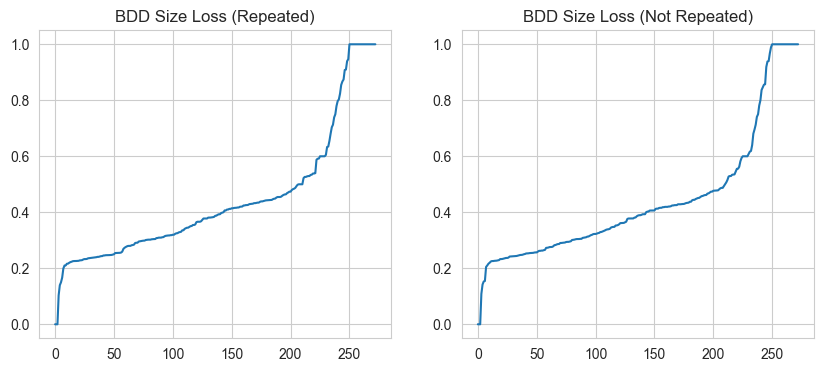

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].plot(np.sort(X["BDD Size Loss (Repeated)"]))
axs[0].set_title("BDD Size Loss (Repeated)")

axs[1].plot(np.sort(X["BDD Size Loss (Not Repeated)"]))
axs[1].set_title("BDD Size Loss (Not Repeated)");

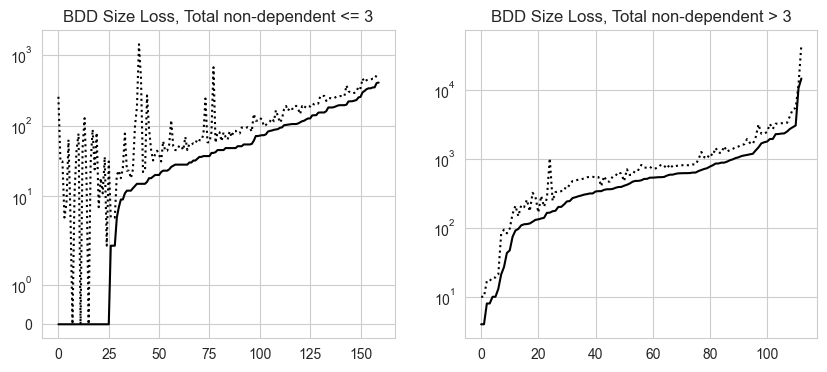

In [18]:
# figs, axs = plt.subplots(1, 1, figsize=(10, 4))
Y = X.copy()
Y = Y.sort_values("Projected Total BDDs Size (Not Repeated)")

figs, axs = plt.subplots(1, 2, figsize=(10, 4))
AX0 = Y[Y["Total Independent Variables"] <= 3]
axs[0].plot(list(AX0["Origin Total BDDs Size (Not Repeated)"]), 'k:')
axs[0].plot(list(AX0["Projected Total BDDs Size (Not Repeated)"]), 'k')
axs[0].set_title("BDD Size Loss, Total non-dependent <= 3")
axs[0].set_yscale("symlog")

AX1 = Y[Y["Total Independent Variables"] > 3]
axs[1].plot(list(AX1["Origin Total BDDs Size (Not Repeated)"]), 'k:')
axs[1].plot(list(AX1["Projected Total BDDs Size (Not Repeated)"]), 'k')
axs[1].set_title("BDD Size Loss, Total non-dependent > 3")
axs[1].set_yscale("symlog")

# figs.legend(["Origin BDD Size", "Projected BDD Size"], loc='upper left', bbox_to_anchor=(1, 1));

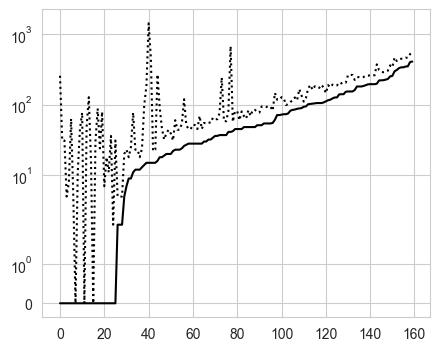

In [30]:
Y = X.copy()
Y = Y.sort_values("Projected Total BDDs Size (Not Repeated)")

figs, axs = plt.subplots(1, 1, figsize=(5, 4))
AX0 = Y[Y["Total Independent Variables"] <= 3]
axs.plot(list(AX0["Origin Total BDDs Size (Not Repeated)"]), 'k:')
axs.plot(list(AX0["Projected Total BDDs Size (Not Repeated)"]), 'k')
# axs.set_title("BDD Size Loss, Total non-dependent <= 3")
axs.set_yscale("symlog")

# AX1 = Y[Y["Total Independent Variables"] > 3]
# axs[1].plot(list(AX1["Origin Total BDDs Size (Not Repeated)"]), 'k:')
# axs[1].plot(list(AX1["Projected Total BDDs Size (Not Repeated)"]), 'k')
# axs[1].set_title("BDD Size Loss, Total non-dependent > 3")
# axs[1].set_yscale("symlog")

# figs.legend(["Origin BDD Size", "Projected BDD Size"], loc='upper left', bbox_to_anchor=(1, 1));

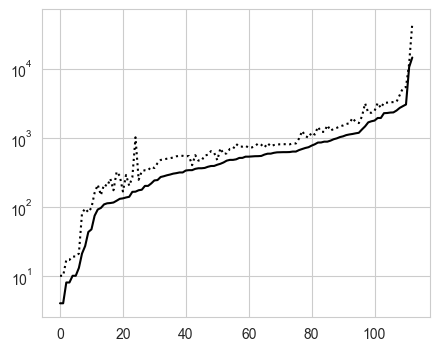

In [29]:
Y = X.copy()
Y = Y.sort_values("Projected Total BDDs Size (Not Repeated)")

figs, axs = plt.subplots(1, 1, figsize=(5, 4))
# AX0 = Y[Y["Total Independent Variables"] <= 3]
# axs.plot(list(AX0["Origin Total BDDs Size (Not Repeated)"]), 'k:')
# axs.plot(list(AX0["Projected Total BDDs Size (Not Repeated)"]), 'k')
# axs.set_title("BDD Size Loss, Total non-dependent <= 3")
# axs.set_yscale("symlog")

AX1 = Y[Y["Total Independent Variables"] > 3]
axs.plot(list(AX1["Origin Total BDDs Size (Not Repeated)"]), 'k:')
axs.plot(list(AX1["Projected Total BDDs Size (Not Repeated)"]), 'k')
# axs.set_title("BDD Size Loss, Total non-dependent > 3")
axs.set_yscale("symlog")

# figs.legend(["Origin BDD Size", "Projected BDD Size"], loc='upper left', bbox_to_anchor=(1, 1));